In [187]:
import shutil
import yaml
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from docopt import docopt
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset, ConcatDataset
from tqdm import tqdm
from torch.optim import lr_scheduler
import math

from data_loading_4x import get_swed_dataset, get_sentinel2_dataset, get_sentinel2_4x_dataset
from deep_learning import get_loss, get_model, Metrics, flatui_cmap, jaccard_loss, bce_loss
from deep_learning.utils.data_4x import Augment

import os

In [188]:

torch.backends.cudnn.benchmark = True

#cli_args = docopt(__doc__, version="Usecase 2 Training Script 1.0")
#config_file = Path(cli_args['--config'])
config_file = Path('config_4x.yml').resolve()
config = yaml.load(config_file.open(), Loader=yaml.SafeLoader)

# How to load in model (copy this and stick segformer loading model here)
modelclass = get_model(config['model'])
model = modelclass(**config['model_args'])

#if cli_args['--resume']:
#    config['resume'] = cli_args['--resume']

if 'resume' in config and config['resume']:
    checkpoint = Path(config['resume'])
    if not checkpoint.exists():
        raise ValueError(f"There is no Checkpoint at {config['resume']} to resume from!")
    if checkpoint.is_dir():
        # Load last checkpoint in run dir
        ckpt_nums = [int(ckpt.stem) for ckpt in checkpoint.glob('checkpoints/*.pt')]
        last_ckpt = max(ckpt_nums)
        config['resume'] = checkpoint / 'checkpoints' / f'{last_ckpt:02d}.pt'
    print(f"Resuming training from checkpoint {config['resume']}")
    # remove map_location=torch.device('cpu') if gpu is available
    model.load_state_dict(torch.load(config['resume'], map_location=torch.device('cpu')))

cuda = True if torch.cuda.is_available() else False
dev = torch.device("cpu") if not cuda else torch.device("cuda")
print(f'Training on {dev} device')
model = model.to(dev)

epoch = 0
metrics = Metrics()

Resuming training from checkpoint logs/2023-07-11_10-59-57/checkpoints/06.pt
Training on cpu device


In [189]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
HEDUNet                                  --
├─Conv2d: 1-1                            224
├─ModuleList: 1-2                        --
│    └─DownBlock: 2-1                    --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             64
│    │    └─ReLU: 3-3                    --
│    │    └─Convx2: 3-4                  55,552
│    └─DownBlock: 2-2                    --
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             128
│    │    └─ReLU: 3-7                    --
│    │    └─Convx2: 3-8                  221,696
│    └─DownBlock: 2-3                    --
│    │    └─Conv2d: 3-9                  65,536
│    │    └─BatchNorm2d: 3-10            256
│    │    └─ReLU: 3-11                   --
│    │    └─Convx2: 3-12                 885,760
│    └─DownBlock: 2-4                    --
│    │    └─Conv2d: 3-13                 262,144
│    │    └─BatchNorm2d: 3-14         

In [191]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils

def visTensordown(tensors, ch=0, allkernels=False, nrow=8, padding=1):
    no_plots = len(tensors)
    fig, axs = plt.subplots(1, no_plots)

    idx = no_plots - 1
    for tensor in tensors:
        tensor = tensor.__dict__['_modules']['convdown'].__dict__['_parameters']['weight']
        n,c,w,h = tensor.shape
        subtitle = f'{n} x {c}'
        
        ax = axs[idx]
        

        if allkernels: tensor = tensor.view(n*c, -1, w, h)
        elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

        cols = np.min((tensor.shape[0] // nrow + 1, 64))    
        grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
        ax.set_title(subtitle)
        #ax.figsize=(nrow,cols)
        ax.imshow(grid.numpy().transpose((1, 2, 0)))

        idx -= 1



def visTensorup(tensors, ch=0, allkernels=False, nrow=8, padding=1):
    no_plots = len(tensors)
    fig, axs = plt.subplots(1, no_plots)

    idx = no_plots - 1
    for tensor in tensors:
        tensor = tensor.__dict__['_modules']['up'].__dict__['_parameters']['weight']
        n,c,w,h = tensor.shape
        subtitle = f'{n} x {c}'
        
        ax = axs[idx]
        

        if allkernels: tensor = tensor.view(n*c, -1, w, h)
        elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

        cols = np.min((tensor.shape[0] // nrow + 1, 64))    
        grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
        ax.set_title(subtitle)
        #ax.figsize=(nrow,cols)
        ax.imshow(grid.numpy().transpose((1, 2, 0)))

        idx -= 1

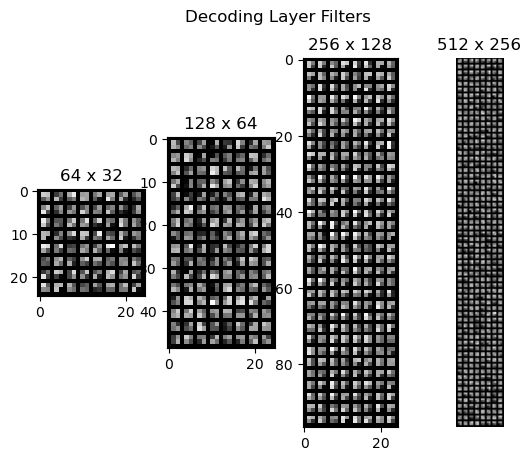

In [193]:
layer = 1
#filter = model.features[layer].weight.data.clone()
filter = model.__dict__['_modules']['up_blocks']
visTensorup(filter, ch=0, allkernels=False)

plt.axis('off')
plt.suptitle('Decoding Layer Filters')
plt.ioff()
plt.show()

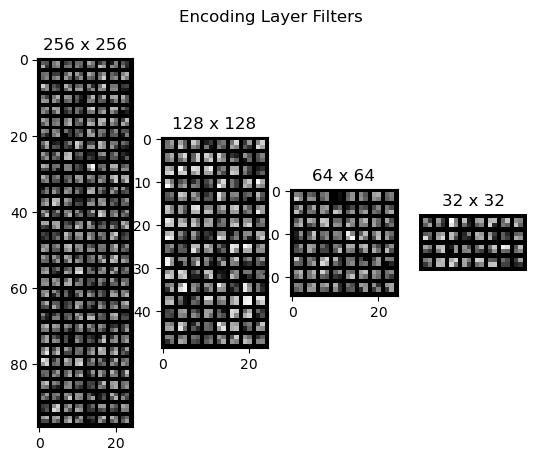

In [192]:
layer = 1
#filter = model.features[layer].weight.data.clone()
filter = model.__dict__['_modules']['down_blocks']
visTensordown(filter, ch=0, allkernels=False)

plt.axis('off')
plt.suptitle('Encoding Layer Filters')
plt.ioff()
plt.show()